# Student++

Modelo Student usando GANS y Transfer Learning a partir de Student

In [1]:
from tensorflow.keras.models import load_model
import os
import sys
import csv
import cv2
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil # para mover archivos
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1,l2, l1_l2
# Clases
from utils import CreateEnvironment, ModDataFrame, ObtenerEtiquetas, SortEnvironment
from utils import InspecTrain_img, Plot_training_performance 
from preprocImage import PreprocData
from cnn import ConvNeuralNetwork

In [7]:
pathBase = "my_dataset/"          # Directorio de data
pathTrain=pathBase+'train/'      # Directorio de train
pathTeacher_models = "models/teacherModels/models/"           # Directorio guardado de modelos teacher
pathPred = pathBase+'noEtiquetadas/'              # Directorio para imagenes no etiquetadas a predecir
pathEtiquetadas = pathBase+'etiquetadas_por_teacher/'
numImages = 1821

# direcciones para guardar modelos e imagenes de Student
pathStudent_models = "models/studentModels/models/"
pathStudent_img = "models/studentModels/img"

# Leer data frame de train
df = pd.read_csv(pathBase + '/train.csv')        
df_train = ModDataFrame(df)
etiquetas = ObtenerEtiquetas(df_train)


Etiquetas de train
['costra', 'multiples_enfermedades', 'oxido', 'saludable']


### Carga de datos originales

In [3]:
batchSize = numImages
targetSize = 192,192

dataTrain_teacher = PreprocData(batchSize,targetSize,pathTrain)  #Objeto para generacion de datos de train y test

# Llamada a función que devuelve data de train y test seárados (segun valSplit) 
# se guardara estos datos de TEST hasta el final durante todo el proceso
dataX, dataY, testX, testY = dataTrain_teacher.trainTest_dataGenerator(rotation=0, rescale=1./255,
                                                                       shear=0, zoom=0,
                                                                       flip_H=False,
                                                                       valSplit=0.2,  # 20% separado para TEST
                                                                       classMode = 'categorical',                                                                       
                                                                       labelNames = etiquetas)

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.
Forma de Datos de train
X: (1458, 192, 192, 3) y: (1458, 4)
Forma de Datos de validation
X: (363, 192, 192, 3) y: (363, 4)


In [4]:
def Get_training_data(datafolder):
    print("Loading training data...")
    training_data = []

    filenames = os.listdir(datafolder)
    for filename in tqdm(filenames):
        #Buscar archivos en la carpeta por nombres
        path = os.path.join(datafolder,filename)
    
        image = Image.open(path)        
        image = image.resize((192,192),Image.ANTIALIAS)   #Cambiar tamaño al tamaño utilizado
        
        pixel_array = np.asarray(image)                   # Crear array a partir de la imagen
        training_data.append(pixel_array)

    training_data = np.reshape(training_data,(-1,192,192,3))   # convertir en Numpyarray
    # Normalizar (0 - 1)
    training_data = training_data.astype(np.float32)
    training_data = training_data * (1./255)
    
    return training_data

### Carga de datos aumentados por teacher al 30%

In [8]:
batchSize_aug = 546             # aumento del 30% (546)

#Objeto para generacion de data augmentarion para train
dataTrain_predicted = PreprocData(batchSize_aug,targetSize,pathEtiquetadas)  

dataX_pred, dataY_pred = dataTrain_predicted.augmentation_dataGenerator(rotation=0, rescale=.1/255, shear=0, zoom=0, 
                                                                        flip_H = False, classMode = 'categorical',                                                                       
                                                                        labelNames = None)

# Adicionamos imagenes al dataset
dataX_student=np.vstack((dataX, dataX_pred))
dataY_student=np.vstack((dataY, dataY_pred))

print(f'imagenes de train iniciales: {dataX.shape[0]}')
print(f'imagenes predichas con teacher: {dataX_pred.shape[0]}')
print(f'imagenes con aumento: {dataX_student.shape[0]}')

Found 2099 images belonging to 4 classes.
imagenes de train iniciales: 1458
imagenes predichas con teacher: 546
imagenes con aumento: 2004


In [9]:
def Show_classification_report(model, test_x, test_y, batchSize_train):
        predictions = model.predict(test_x, batch_size=batchSize_train)
        pred = np.argmax(predictions, axis=1)
        test_y = np.argmax(test_y, axis=1)
        print(classification_report(test_y, pred, target_names=etiquetas))

## Cargar de modelo Student

In [263]:
# cargar modelos guardados
StudentModel_1_30 = load_model(pathStudent_models+'studentModel_1_30.h5')

In [12]:
pathGeneratedCGAN = 'imagenesGeneradasCgan/'      # Directorio para imagenes generadas con cycleGANS

# Leer data frame de train
df = pd.read_csv(pathBase + '/train.csv')        
df_train = ModDataFrame(df)
etiquetas = ObtenerEtiquetas(df_train)

print("\nEquivalencias en one hot encoding\n")
for j in range(4):
    print(f"{etiquetas[j]} ->  {dataY[j]}")


Etiquetas de train
['costra', 'multiples_enfermedades', 'oxido', 'saludable']

Equivalencias en one hot encoding

costra ->  [0. 0. 0. 1.]
multiples_enfermedades ->  [0. 0. 1. 0.]
oxido ->  [1. 0. 0. 0.]
saludable ->  [0. 1. 0. 0.]


In [13]:
# Función para preparar imagenes creadas por cycleGANs igual que los datos de train
def PrepocDataCGANS(data_augCGAN,folder):
    X_gen, Y_gen = data_augCGAN.augmentation_dataGenerator(rotation=0, rescale=1./255, shear=0, zoom=0,
                                                            flip_H = False, classMode = 'categorical',                                                                       
                                                            labelNames = [folder,'no1','no2','no3'])    
    return X_gen, Y_gen

In [20]:
batchSize_aug = 64

# Objeto para adecuación de datos augmentados creados a partir de cycleGANs
data_augCGAN = PreprocData(batchSize_aug,targetSize,pathGeneratedCGAN)  

X_costra_a_multEnf, Y_costra_a_multEnf = PrepocDataCGANS(data_augCGAN,'costra_a_multEnf')
X_costra_a_oxido, Y_costra_a_oxido = PrepocDataCGANS(data_augCGAN,'costra_a_oxido')
X_oxido_a_multEnf, Y_oxido_a_multEnf = PrepocDataCGANS(data_augCGAN,'oxido_a_multEnf')
X_saludable_a_costra, Y_saludable_a_costra = PrepocDataCGANS(data_augCGAN,'saludable_a_costra')
X_saludable_a_multEnf, Y_saludable_a_multEnf = PrepocDataCGANS(data_augCGAN,'saludable_a_multEnf')
X_saludable_a_oxido, Y_saludable_a_oxido = PrepocDataCGANS(data_augCGAN,'saludable_a_oxido')

# etiquetar según carpeta creada con cycleGANs (one hot encoding)
for i in range(batchSize_aug):
    Y_costra_a_multEnf[i]    =  [0., 0., 1., 0.]  # Multiples enfermedades
    Y_costra_a_oxido[i]      =  [0., 0., 1., 0.]  # Multiples enfermedades
    Y_oxido_a_multEnf[i]     =  [0., 0., 1., 0.]  # Multiples enfermedades
    Y_saludable_a_costra[i]  =  [0., 0., 0., 1.]  # Costra
    Y_saludable_a_multEnf[i] =  [0., 0., 1., 0.]  # Multiples enfermedades
    Y_saludable_a_oxido[i]   =  [1., 0., 0., 0.]  # Oxido
    
# Adicionamos imagenes al dataset
dataX_compound=np.vstack((dataX_student, X_costra_a_oxido))
dataY_compound=np.vstack((dataY_student, Y_costra_a_oxido))

dataX_compound=np.vstack((dataX_compound, X_costra_a_multEnf))
dataY_compound=np.vstack((dataY_compound, Y_costra_a_multEnf))

dataX_compound=np.vstack((dataX_compound, X_costra_a_oxido))
dataY_compound=np.vstack((dataY_compound, Y_costra_a_oxido))

dataX_compound=np.vstack((dataX_compound, X_oxido_a_multEnf))
dataY_compound=np.vstack((dataY_compound, Y_oxido_a_multEnf))

dataX_compound=np.vstack((dataX_compound, X_saludable_a_costra))
dataY_compound=np.vstack((dataY_compound, Y_saludable_a_costra))

dataX_compound=np.vstack((dataX_compound, X_saludable_a_multEnf))
dataY_compound=np.vstack((dataY_compound, Y_saludable_a_multEnf))

dataX_compound=np.vstack((dataX_compound, X_saludable_a_oxido))
dataY_compound=np.vstack((dataY_compound, Y_saludable_a_oxido))

print(f'imagenes iniciales: {dataX.shape[0]}')
print(f'imagenes iniciales con self: {dataX_student.shape[0]}')
print(f'imagenes con aumento de gans: {dataX_compound.shape[0]}')

Found 515 images belonging to 4 classes.
Found 515 images belonging to 4 classes.
Found 542 images belonging to 4 classes.
Found 453 images belonging to 4 classes.
Found 453 images belonging to 4 classes.
Found 453 images belonging to 4 classes.
imagenes iniciales: 1458
imagenes iniciales con self: 2004
imagenes con aumento de gans: 2452


In [21]:
# Congelar bloques
studentModel_comp_1 = StudentModel_1_30
studentModel_comp_1.trainable = True

for layer in studentModel_comp_1.layers: 
#     if layer.name == 'conv2d_5': 
#     if layer.name == 'conv2d_3': 
    if layer.name == 'flatten': 
        break 
    layer.trainable = False 
    print('Capa ' + layer.name + ' congelada') 

Capa conv2d congelada
Capa batch_normalization congelada
Capa max_pooling2d congelada
Capa dropout congelada
Capa conv2d_1 congelada
Capa batch_normalization_1 congelada
Capa max_pooling2d_1 congelada
Capa dropout_1 congelada
Capa conv2d_2 congelada
Capa batch_normalization_2 congelada
Capa max_pooling2d_2 congelada
Capa dropout_2 congelada
Capa conv2d_3 congelada
Capa batch_normalization_3 congelada
Capa max_pooling2d_3 congelada
Capa dropout_3 congelada
Capa conv2d_4 congelada
Capa batch_normalization_4 congelada
Capa max_pooling2d_4 congelada
Capa dropout_4 congelada
Capa conv2d_5 congelada
Capa batch_normalization_5 congelada
Capa max_pooling2d_5 congelada
Capa dropout_5 congelada


In [22]:
epochs=40

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
studentModel_comp_1.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["accuracy"]) 

#Callbacks
model_cp = ModelCheckpoint(pathStudent_models+"_studentModel_comp_1.h5", monitor='val_loss', verbose=0, save_best_only=True, 
                           save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)

callbacks_list = [model_cp, early_stop, reduce_lr]

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_student_comp_1=studentModel_comp_1.fit(dataX_compound, dataY_compound, batch_size=8, epochs=epochs,         
                             validation_split = 0.2, callbacks=callbacks_list)

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/40
246/246 [==============================] - 28s 109ms/step - loss: 1.2807 - accuracy: 0.7517 - val_loss: 3.5150 - val_accuracy: 0.3544
Epoch 2/40
246/246 [==============================] - 27s 110ms/step - loss: 1.4055 - accuracy: 0.7384 - val_loss: 3.1676 - val_accuracy: 0.3890
Epoch 3/40
246/246 [==============================] - 26s 108ms/step - loss: 1.5086 - accuracy: 0.7440 - val_loss: 3.5692 - val_accuracy: 0.3035
Epoch 4/40
246/246 [==============================] - 26s 107ms/step - loss: 1.5133 - accuracy: 0.7557 - val_loss: 3.3972 - val_accuracy: 0.2566
Epoch 5/40
246/246 [==============================] - 26s 106ms/step - loss: 1.4680 - accuracy: 0.7476 - val_loss: 3.0359 - val_accuracy: 0.4134
Epoch 6/40
246/246 [==============================] - 26s 107ms/step - loss: 1.4668 - accuracy: 0.7557 - val_loss: 3.3219 - val_accuracy: 0.3381
Epoch 7/40
246/246 [==============================] - 26s 106ms/step 

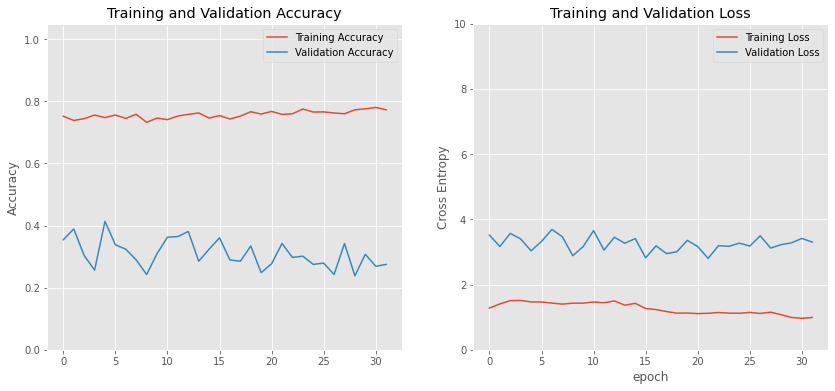

                        precision    recall  f1-score   support

                costra       0.97      0.95      0.96       118
multiples_enfermedades       0.69      0.50      0.58        18
                 oxido       0.95      0.97      0.96       124
             saludable       0.94      0.98      0.96       103

              accuracy                           0.94       363
             macro avg       0.89      0.85      0.86       363
          weighted avg       0.94      0.94      0.94       363



In [27]:
Plot_training_performance(H_student_comp_1, 32, pathStudent_img+'/studentModel_comp_1')
# pruebas con datos de Test
Show_classification_report(studentModel_comp_1,testX, testY, 8)

In [28]:
loss, acc = studentModel_comp_1.evaluate(testX, testY, verbose=2)

12/12 - 2s - loss: 0.6245 - accuracy: 0.9421


In [29]:
studentModel_comp_1.save(pathStudent_models+"studentModel_comp_1.h5")

In [60]:
# Pruebas con modelo student compuesto por datos predichos de teacher e imagenes generadas por cycleGANs
StudentModel_comp = load_model(pathStudent_models+'studentModel_comp_1.h5')
loss, acc = StudentModel_comp.evaluate(testX, testY, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
Show_classification_report(StudentModel_comp,testX, testY, 128)

12/12 - 2s - loss: 0.6245 - accuracy: 0.9421
Restored model, accuracy: 94.21%
                        precision    recall  f1-score   support

                costra       0.97      0.95      0.96       118
multiples_enfermedades       0.69      0.50      0.58        18
                 oxido       0.95      0.97      0.96       124
             saludable       0.94      0.98      0.96       103

              accuracy                           0.94       363
             macro avg       0.89      0.85      0.86       363
          weighted avg       0.94      0.94      0.94       363



## Visualización de funcionamiento de CNN Student++

In [70]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from numpy import expand_dims

import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 2

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

In [71]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
    

X =dataX[0:4]
    
# SCORE
score = CategoricalScore([0, 1, 2, 3])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    return (output[0][1], output[1][1], output[2][5], output[3][0])

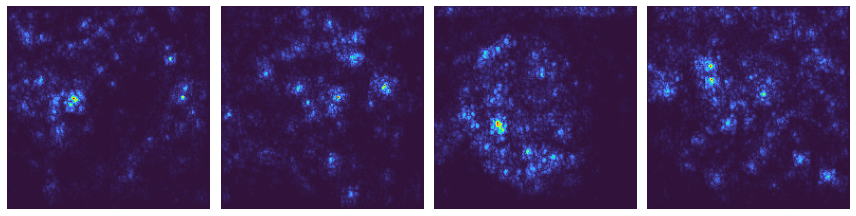

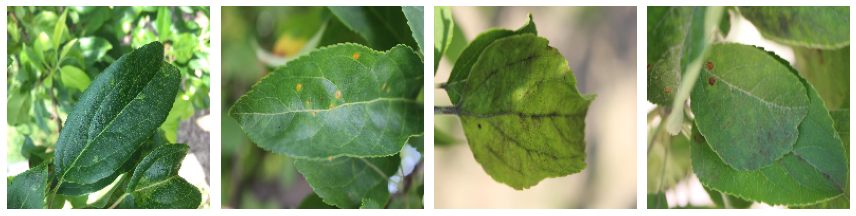

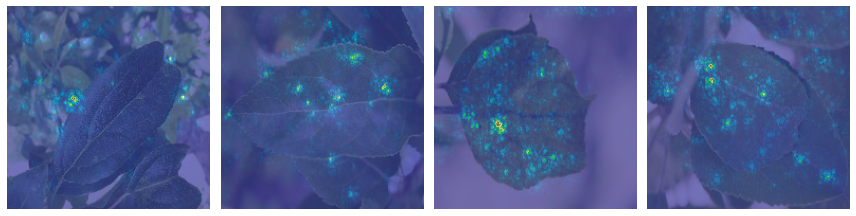

Wall time: 856 ms


In [74]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Create Saliency object.
saliency = Saliency(StudentModel_comp,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

# Render
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i in range(4):
    ax[i].imshow(saliency_map[i], cmap='turbo')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i in range(4):
    ax[i].imshow(X[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i in range(4):
    ax[i].imshow(X[i])
    ax[i].imshow(saliency_map[i], cmap='terrain', alpha=0.7) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

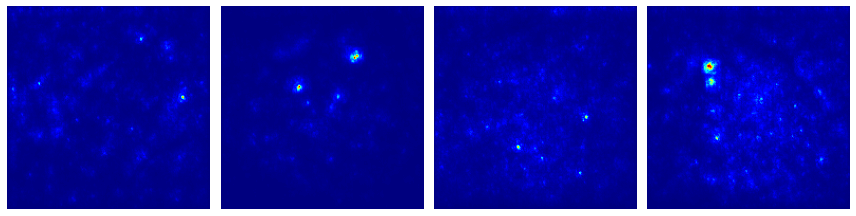

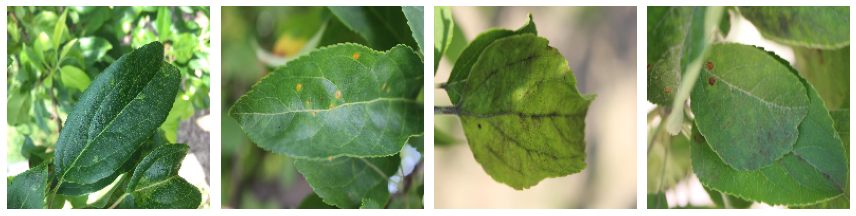

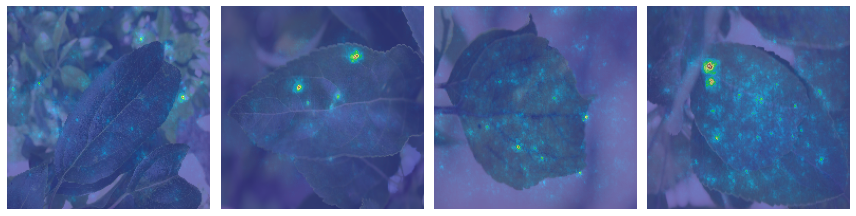

Wall time: 4.08 s


In [86]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

# Render
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i in range(4):
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i in range(4):
    ax[i].imshow(X[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i in range(4):
    ax[i].imshow(X[i])
    ax[i].imshow(saliency_map[i], cmap='terrain', alpha=0.7) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

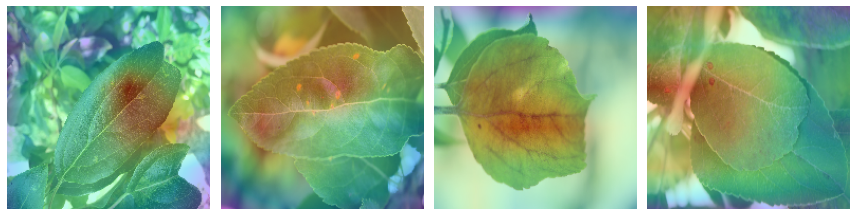

Wall time: 11.3 s


In [82]:
%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(StudentModel_comp)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i in range(4):
    heatmap = np.uint8(cm.rainbow(cam[i])[..., :3] * 255)
    ax[i].imshow(X[i])
    ax[i].imshow(heatmap, cmap='rainbow', alpha=0.4)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Visualizando caracteristicas por capas

In [87]:
for i in range(len(StudentModel_comp.layers)):
    layer = StudentModel_comp.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

0 conv2d (None, 192, 192, 32)
4 conv2d_1 (None, 96, 96, 64)
8 conv2d_2 (None, 48, 48, 64)
12 conv2d_3 (None, 24, 24, 128)
16 conv2d_4 (None, 12, 12, 128)
20 conv2d_5 (None, 6, 6, 256)


In [259]:
imageC = load_img(pathTrain+"multiples_enfermedades/Train_1050.jpg" , target_size=(192,192))

image = img_to_array(imageC)
image = expand_dims(image, axis=0)
image = image/255

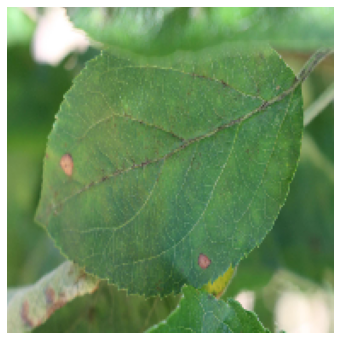

In [260]:
fig = plt.figure(figsize=(6,6))
plt.imshow(imageC)
plt.axis('off')
plt.show()

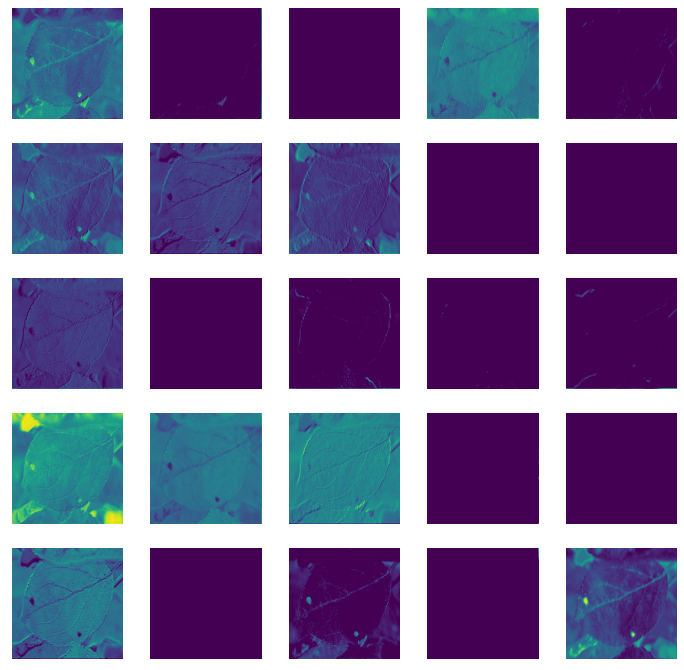

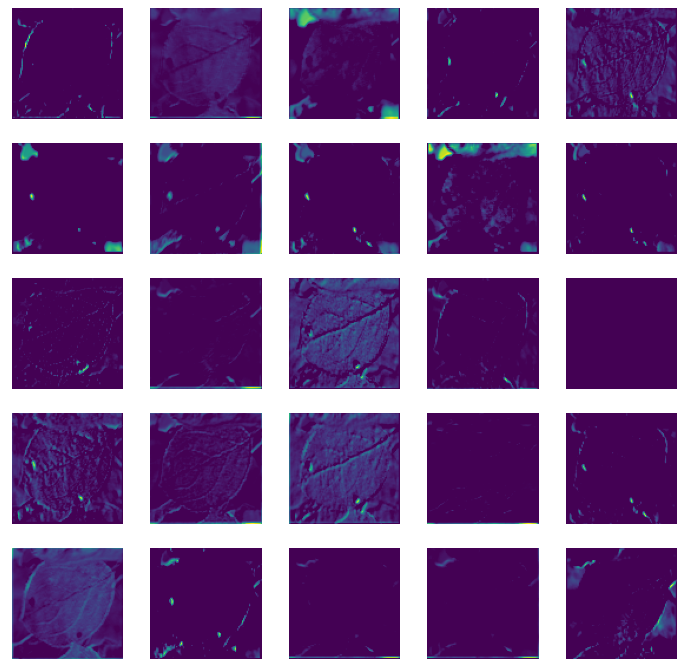

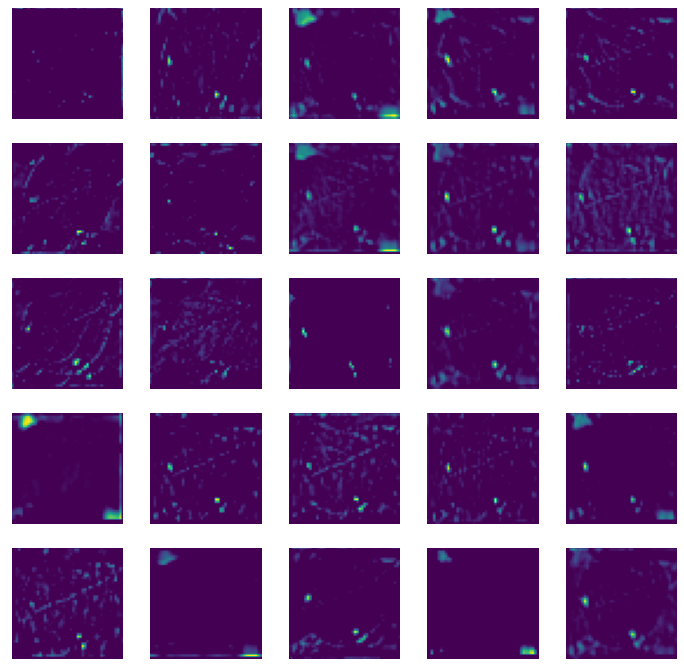

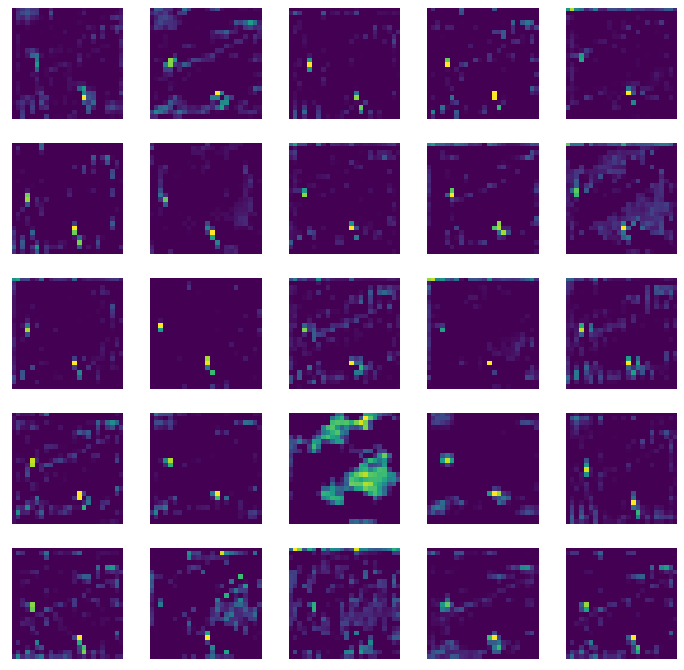

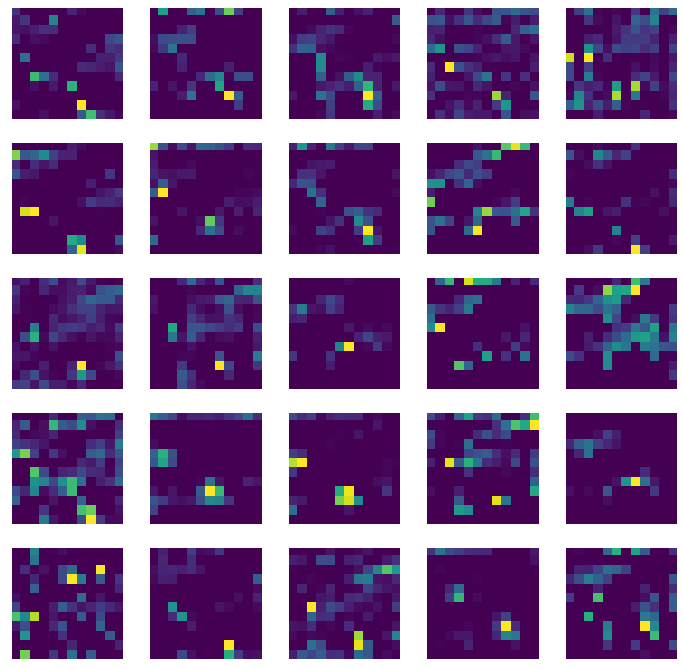

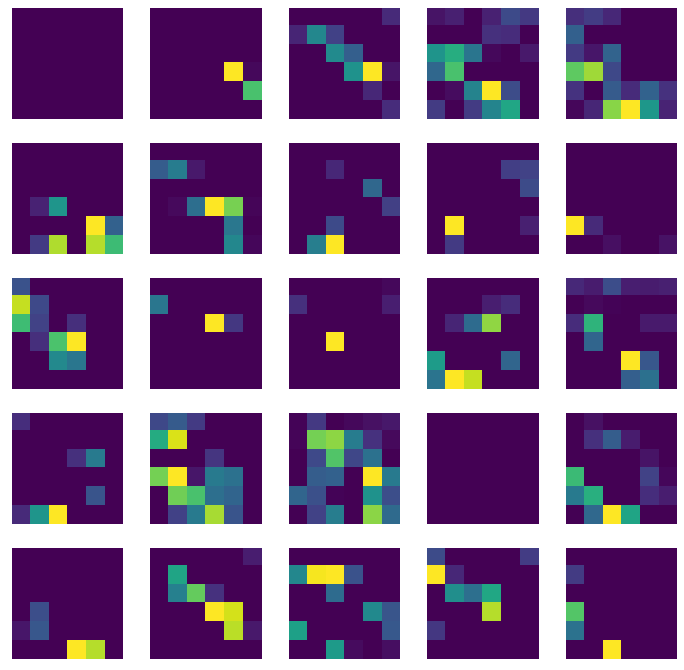

In [261]:
feature_maps = model2.predict(image)
# plot the output from each block
square = 5
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
            ix += 1
    plt.rcParams["figure.figsize"] = (12, 12)
    plt.show()